# Candidate Ambiguity & Quality Weight

**Purpose:** Analyze structural ambiguity (header replication causing multiple
candidates) and the quality weight that combines overlap fidelity with ambiguity.

1. **Candidate count distribution** — two-panel view: all functions (showing
   that most have a unique match) and zoom into multi-candidate functions.
2. **Quality weight distribution** — violin + strip plot showing the weight
   that will be used to scale downstream LLM scores.

In [1]:
## ── Imports & Style ──────────────────────────────────────────────────────────

from pathlib import Path
import sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

sys.path.insert(0, str(Path("../..").resolve()))

from data import (
    load_dataset, enrich_pairs,
    AlignmentVerdict, AlignmentReason, OracleVerdict,
)

warnings.filterwarnings("ignore", category=FutureWarning)

OPT_COLORS = {"O0": "#4daf4a", "O1": "#377eb8", "O2": "#ff7f00", "O3": "#e41a1c"}

THESIS_RC = {
    "font.family": "serif", "font.size": 10,
    "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "legend.fontsize": 9, "figure.dpi": 120,
    "savefig.dpi": 300, "savefig.bbox": "tight",
    "figure.figsize": (7, 4.5),
    "axes.spines.top": False, "axes.spines.right": False,
}
plt.rcParams.update(THESIS_RC)
sns.set_context("paper", rc=THESIS_RC)

FIG_DIR = Path("../../figures/oracle_analysis")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name: str, fig=None):
    fig = fig or plt.gcf()
    for ext in ("pdf", "png"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight")
    print(f"  → saved {FIG_DIR / name}.{{pdf,png}}")

print("✓ imports & style ready")

✓ imports & style ready


In [2]:
## ── Load Data ────────────────────────────────────────────────────────────────

SELECTED_TESTS: list[str] | None = None
OPT_LEVELS = ["O0", "O1", "O2", "O3"]
VARIANT = "debug"

ds = load_dataset(
    Path("../../docker/local-files/artifacts/synthetic"),
    test_cases=SELECTED_TESTS,
    opt_levels=OPT_LEVELS,
    variant=VARIANT,
)

df_pairs = enrich_pairs(ds.pairs)
tests    = ds.test_cases

print(f"✓ {len(tests)} test cases, {len(df_pairs)} pairs")
print(f"  quality_weight range: [{df_pairs['quality_weight'].min():.3f}, "
      f"{df_pairs['quality_weight'].max():.3f}]")

✓ 15 test cases, 702 pairs
  quality_weight range: [0.000, 1.000]


---
## Plot 1 — Candidate Count Distribution (Two-Panel)

**What it shows:** How many tree-sitter candidate functions compete for each
DWARF function across all loaded optimization levels.

**How it's computed:**

```
n_candidates = len(candidates)
```

where `candidates` is the list of all tree-sitter functions that had any overlap
with this DWARF function's address range. The best match is *inside* this list
(not separate — this was BUG-2 in the old code).

**Two panels:**
- **Left:** All functions — shows that the vast majority have exactly 1 candidate
  (unique best match).
- **Right:** Only functions with 2+ candidates — zooms into the ambiguous subset.
  Hatched segments indicate `HEADER_REPLICATION_COLLISION` — the same inline
  function was compiled into multiple translation units from a shared header.

**Important caveat:** A unique match (`n_candidates = 1`) does *not* guarantee
alignment fidelity. If the compiler has inlined foreign code into the function,
`overlap_ratio` may be < 1.0 even with a single candidate. See the
"Unique Match Quality" cross-reference table below.

**Why two panels:** With one panel, the `n_candidates=1` bar dominates so
completely that the 2+ bars are invisible. The zoom reveals the structure.

  → saved ..\..\figures\oracle_analysis\09_candidate_count.{pdf,png}


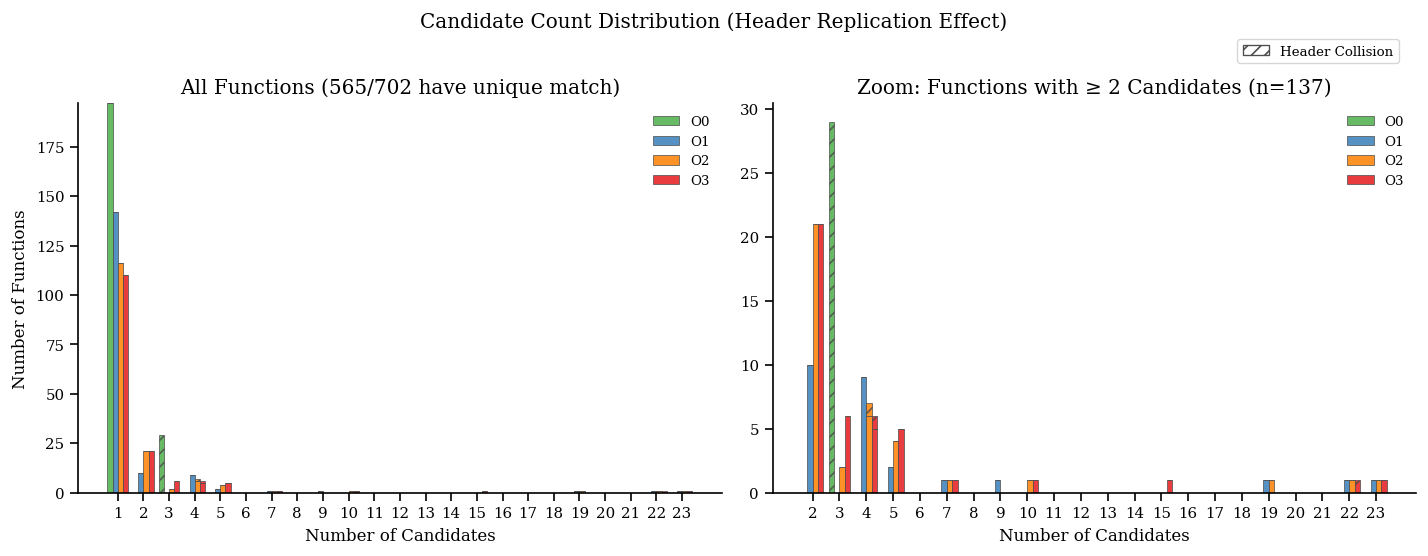

In [3]:
## ── Plot 1: Candidate Count — Two-Panel ─────────────────────────────────────

# Pre-compute header collision flag
df_pairs["is_header_collision"] = df_pairs["reasons"].apply(
    lambda r: AlignmentReason.HEADER_REPLICATION_COLLISION.value in r
)

fig, (ax_all, ax_zoom) = plt.subplots(1, 2, figsize=(12, 4.5))

max_cand = int(df_pairs["n_candidates"].max()) if not df_pairs.empty else 5
n_opts = len(OPT_LEVELS)
bar_width = 0.8 / n_opts  # width of each bar within a group

# ── Left panel: all candidates (grouped bars) ────────────────────────────────
cand_values_all = np.arange(1, max_cand + 1)

for i, opt in enumerate(OPT_LEVELS):
    sub = df_pairs[df_pairs["opt"] == opt]
    counts_other = []
    counts_hdr = []
    for c in cand_values_all:
        mask_c = sub["n_candidates"] == c
        counts_other.append((mask_c & ~sub["is_header_collision"]).sum())
        counts_hdr.append((mask_c & sub["is_header_collision"]).sum())

    x = cand_values_all + (i - n_opts / 2 + 0.5) * bar_width
    ax_all.bar(x, counts_other, width=bar_width, color=OPT_COLORS[opt],
               edgecolor="0.3", linewidth=0.5, alpha=0.85, label=opt)
    ax_all.bar(x, counts_hdr, width=bar_width, bottom=counts_other,
               color=OPT_COLORS[opt], edgecolor="0.3", linewidth=0.5,
               alpha=0.85, hatch="///")

n_unique = (df_pairs["n_candidates"] == 1).sum()
n_total = len(df_pairs)
ax_all.set_xlabel("Number of Candidates")
ax_all.set_ylabel("Number of Functions")
ax_all.set_title(f"All Functions ({n_unique}/{n_total} have unique match)")
ax_all.set_xticks(cand_values_all)
ax_all.legend(fontsize=8, frameon=False)

# ── Right panel: zoom into n_candidates >= 2 (grouped bars) ──────────────────
df_multi = df_pairs[df_pairs["n_candidates"] >= 2]
if not df_multi.empty:
    max_cand_zoom = int(df_multi["n_candidates"].max())
    cand_values_zoom = np.arange(2, max_cand_zoom + 1)

    for i, opt in enumerate(OPT_LEVELS):
        sub = df_multi[df_multi["opt"] == opt]
        counts_other = []
        counts_hdr = []
        for c in cand_values_zoom:
            mask_c = sub["n_candidates"] == c
            counts_other.append((mask_c & ~sub["is_header_collision"]).sum())
            counts_hdr.append((mask_c & sub["is_header_collision"]).sum())

        x = cand_values_zoom + (i - n_opts / 2 + 0.5) * bar_width
        ax_zoom.bar(x, counts_other, width=bar_width, color=OPT_COLORS[opt],
                    edgecolor="0.3", linewidth=0.5, alpha=0.85, label=opt)
        ax_zoom.bar(x, counts_hdr, width=bar_width, bottom=counts_other,
                    color=OPT_COLORS[opt], edgecolor="0.3", linewidth=0.5,
                    alpha=0.85, hatch="///")

    ax_zoom.set_xlabel("Number of Candidates")
    ax_zoom.set_title(f"Zoom: Functions with ≥ 2 Candidates (n={len(df_multi)})")
    ax_zoom.set_xticks(cand_values_zoom)
    ax_zoom.legend(fontsize=8, frameon=False)
else:
    ax_zoom.text(0.5, 0.5, "No multi-candidate functions",
                 ha="center", va="center", transform=ax_zoom.transAxes)

# Shared hatching legend
from matplotlib.patches import Patch
hatch_patch = Patch(facecolor="white", edgecolor="0.3", hatch="///", label="Header Collision")
fig.legend(handles=[hatch_patch], loc="upper right", bbox_to_anchor=(0.98, 0.98),
           fontsize=8, frameon=True, facecolor="white")

plt.suptitle("Candidate Count Distribution (Header Replication Effect)", y=1.02)
plt.tight_layout()
save_fig("09_candidate_count")
plt.show()

---
## Plot 1b — Ambiguity Rate by Optimization Level (Potential Thesis Figure)

**What it shows:** The *fraction* of functions at each optimization level that
fall into three categories:

1. **Unique match** — exactly 1 candidate (unambiguous alignment)
2. **Multi-candidate: header collision** — 2+ candidates caused by the same
   function being compiled into multiple translation units from a shared header
3. **Multi-candidate: other** — 2+ candidates from other structural causes

**Why normalized (%):** Raw counts are misleading because higher optimization
levels eliminate functions through inlining. Showing rates makes opt levels
directly comparable.

**Research question this plot answers:**

> *Does optimization affect the header-collision share of structural ambiguity,
> or do header-defined functions get eliminated alongside other functions?*

Note that `static inline` header functions are themselves prime candidates
for elimination at higher optimization levels — the direction of the effect
is an empirical question, not a given.

**Annotations:** Each segment shows its percentage. The total function count
per opt level is shown below the x-axis label so the reader knows the
denominator.

  O0: 12.8% ambiguous, of which 100% is header collision (n=226)
  O1: 15.5% ambiguous, of which 0% is header collision (n=168)
  O2: 25.2% ambiguous, of which 3% is header collision (n=155)
  O3: 28.1% ambiguous, of which 5% is header collision (n=153)
  → saved ..\..\figures\oracle_analysis\09b_ambiguity_rate.{pdf,png}


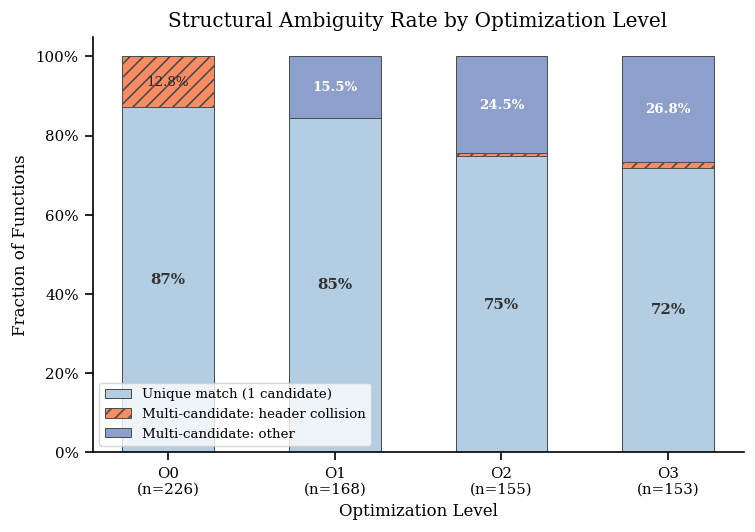

In [4]:
## ── Plot 1b: Ambiguity Rate — Normalized Stacked Bar ─────────────────────────
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(7, 4.5))

# Pre-compute header collision flag (idempotent if already done)
if "is_header_collision" not in df_pairs.columns:
    df_pairs["is_header_collision"] = df_pairs["reasons"].apply(
        lambda r: AlignmentReason.HEADER_REPLICATION_COLLISION.value in r
    )

# Compute rates per opt level
categories = []
for opt in OPT_LEVELS:
    sub = df_pairs[df_pairs["opt"] == opt]
    n_total = len(sub)
    if n_total == 0:
        categories.append((opt, 0, 0, 0, 0))
        continue
    n_unique = (sub["n_candidates"] == 1).sum()
    n_multi_hdr = ((sub["n_candidates"] >= 2) & sub["is_header_collision"]).sum()
    n_multi_other = ((sub["n_candidates"] >= 2) & ~sub["is_header_collision"]).sum()
    categories.append((opt, n_total, n_unique / n_total, n_multi_hdr / n_total, n_multi_other / n_total))

opts      = [c[0] for c in categories]
n_totals  = [c[1] for c in categories]
r_unique  = [c[2] for c in categories]
r_hdr     = [c[3] for c in categories]
r_other   = [c[4] for c in categories]

x = np.arange(len(opts))
bar_w = 0.55

# Stacked bars
bars_unique = ax.bar(x, r_unique, bar_w, color="#b3cde3", edgecolor="0.3", linewidth=0.6,
                     label="Unique match (1 candidate)")
bars_hdr    = ax.bar(x, r_hdr, bar_w, bottom=r_unique, color="#fc8d62", edgecolor="0.3",
                     linewidth=0.6, hatch="///", label="Multi-candidate: header collision")
bars_other  = ax.bar(x, r_other, bar_w,
                     bottom=[u + h for u, h in zip(r_unique, r_hdr)],
                     color="#8da0cb", edgecolor="0.3", linewidth=0.6,
                     label="Multi-candidate: other")

# Percentage annotations inside bars
for i in range(len(opts)):
    # Unique segment (only if large enough)
    if r_unique[i] > 0.05:
        ax.text(x[i], r_unique[i] / 2, f"{r_unique[i]:.0%}",
                ha="center", va="center", fontsize=9, fontweight="bold", color="0.2")

    # Header collision segment
    if r_hdr[i] > 0.02:
        y_mid = r_unique[i] + r_hdr[i] / 2
        ax.text(x[i], y_mid, f"{r_hdr[i]:.1%}",
                ha="center", va="center", fontsize=8, color="0.15")

    # Other segment
    if r_other[i] > 0.02:
        y_mid = r_unique[i] + r_hdr[i] + r_other[i] / 2
        ax.text(x[i], y_mid, f"{r_other[i]:.1%}",
                ha="center", va="center", fontsize=8, color="white", fontweight="bold")

# X-axis: opt level + function count
ax.set_xticks(x)
ax.set_xticklabels([f"{opt}\n(n={n})" for opt, n in zip(opts, n_totals)])
ax.set_xlabel("Optimization Level")
ax.set_ylabel("Fraction of Functions")
ax.set_ylim(0, 1.05)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.0%}"))  # type: ignore

ax.legend(loc="lower left", fontsize=8, frameon=True, facecolor="white", edgecolor="0.8")
ax.set_title("Structural Ambiguity Rate by Optimization Level")

# Print summary for thesis text
for i, opt in enumerate(opts):
    multi_rate = r_hdr[i] + r_other[i]
    hdr_share = r_hdr[i] / multi_rate * 100 if multi_rate > 0 else 0
    print(f"  {opt}: {multi_rate:.1%} ambiguous, "
          f"of which {hdr_share:.0f}% is header collision (n={n_totals[i]})")

save_fig("09b_ambiguity_rate")
plt.show()

---
## Plot 2 — Quality Weight Distribution

**What it shows:** The distribution of `quality_weight` at each optimization level,
using a violin + strip plot.

**Function used:** `enrich_pairs()` → `quality_weight` column

**How it's computed:**

The quality weight combines two independent dimensions into a single number:

```
if verdict == MATCH:
    quality_weight = overlap_ratio / n_candidates
else:
    quality_weight = 0
```

Breaking this down:

- **`overlap_ratio`** (range 0 to 1): What fraction of the DWARF function's
  line-table rows map to the best tree-sitter candidate. A value of 1.0 means
  every line row was accounted for; lower values mean some rows pointed to
  other files (typically from inlined code).

- **`1 / n_candidates`** (range 0 to 1): Ambiguity penalty. If there's 1 candidate,
  no penalty (multiply by 1). If there are 3 candidates, multiply by 1/3.
  More candidates = less certainty the best one is correct.

- **Non-MATCH = 0:** AMBIGUOUS and NO_MATCH pairs should never serve as ground
  truth for downstream scoring, so they get weight zero.

**Why not `overlap_ratio × (1 - gap_rate)`?** Because `gap_rate = 1 - overlap_ratio`
by construction (gap_count = total_count − overlap_count). That product would
just be overlap_ratio², which adds no information. `n_candidates` is genuinely
independent — it depends on how many TU copies exist, not on line coverage.

**Annotations:** P5 (5th percentile) instead of median, because median is 1.0
for most datasets (most functions match perfectly). P5 captures the lower tail
where degradation lives.

  O0: 29/226 pairs have quality_weight=0 (non-MATCH)
  O1: 14/168 pairs have quality_weight=0 (non-MATCH)
  O2: 22/155 pairs have quality_weight=0 (non-MATCH)
  O3: 25/153 pairs have quality_weight=0 (non-MATCH)
  → saved ..\..\figures\oracle_analysis\10_quality_weight_violin.{pdf,png}


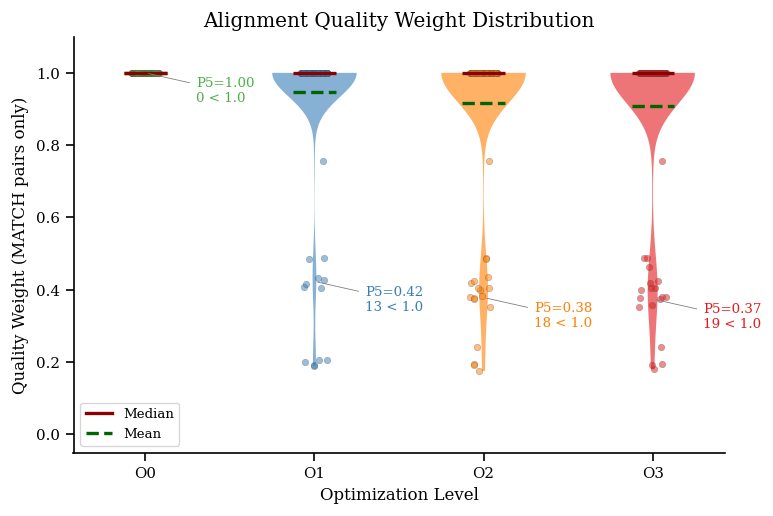

In [5]:
## ── Plot 2: Quality Weight Violin + Strip ────────────────────────────────────

fig, ax = plt.subplots(figsize=(7, 4.5))

# Filter to MATCH-only for meaningful distribution (non-match is all 0)
df_match = df_pairs[df_pairs["verdict"] == AlignmentVerdict.MATCH.value]

if not df_match.empty:
    weight_data = [
        df_match[df_match["opt"] == opt]["quality_weight"].dropna().values
        for opt in OPT_LEVELS
    ]

    parts = ax.violinplot(
        weight_data,  # type: ignore
        positions=range(len(OPT_LEVELS)),
        showmeans=True, showmedians=True, showextrema=False,
    )

    for i, pc in enumerate(parts["bodies"]):  # type: ignore
        pc.set_facecolor(OPT_COLORS[OPT_LEVELS[i]])
        pc.set_alpha(0.6)
    
    # Make median and mean lines more visible
    parts["cmedians"].set_edgecolor("darkred")  # type: ignore
    parts["cmedians"].set_linewidth(2)  # type: ignore
    parts["cmeans"].set_edgecolor("darkgreen")  # type: ignore
    parts["cmeans"].set_linewidth(2)  # type: ignore
    parts["cmeans"].set_linestyle("--")  # type: ignore

    # Strip plot overlay
    rng = np.random.default_rng(42)
    for i, opt in enumerate(OPT_LEVELS):
        vals = df_match[df_match["opt"] == opt]["quality_weight"].dropna().values
        jitter = rng.uniform(-0.08, 0.08, size=len(vals))
        ax.scatter(i + jitter, vals, color=OPT_COLORS[opt], s=15, alpha=0.5,  # type: ignore
                   edgecolors="0.3", linewidths=0.3)

    # P5 annotation (5th percentile — captures the lower tail)
    for i, opt in enumerate(OPT_LEVELS):
        vals = df_match[df_match["opt"] == opt]["quality_weight"].dropna()
        p5 = vals.quantile(0.05)
        n_below_1 = (vals < 1.0).sum()
        ax.annotate(
            f"P5={p5:.2f}\n{n_below_1} < 1.0",
            xy=(i, p5), xytext=(i + 0.3, p5 - 0.08),
            fontsize=8, color=OPT_COLORS[opt],
            arrowprops=dict(arrowstyle="-", color="0.5", lw=0.5),
        )

ax.set_xticks(range(len(OPT_LEVELS)))
ax.set_xticklabels(OPT_LEVELS)
ax.set_xlabel("Optimization Level")
ax.set_ylabel("Quality Weight (MATCH pairs only)")
ax.set_title("Alignment Quality Weight Distribution")
ax.set_ylim(-0.05, 1.1)

# Legend for violin plot lines
legend_elements = [
    Line2D([0], [0], color='darkred', linewidth=2, linestyle='-', label='Median'),
    Line2D([0], [0], color='darkgreen', linewidth=2, linestyle='--', label='Mean'),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=8, frameon=True)

# Count annotation: how many pairs have w=0 (non-match)
for opt in OPT_LEVELS:
    n_zero = (df_pairs[(df_pairs["opt"] == opt)]["quality_weight"] == 0).sum()
    n_all = len(df_pairs[df_pairs["opt"] == opt])
    print(f"  {opt}: {n_zero}/{n_all} pairs have quality_weight=0 (non-MATCH)")

save_fig("10_quality_weight_violin")
plt.show()

---
## Unique Match Quality Cross-Reference

**Why this matters:** A unique match (`n_candidates = 1`) means there is no
structural ambiguity — only one tree-sitter function competes. However,
uniqueness does not guarantee alignment *fidelity*. If the compiler has
inlined foreign code into the function's address range, the
`overlap_ratio` will be < 1.0 even with a single candidate. This table
quantifies that gap.

Breakdown per optimization level:

- **unique & perfect** — `n_candidates = 1` AND `overlap_ratio = 1.0`.
  The ideal case: unambiguous *and* faithful alignment.
- **unique & degraded** — `n_candidates = 1` BUT `overlap_ratio < 1.0`.
  Unambiguous selection, but the DWARF scope contains foreign line rows
  (typically from inlined callees). The alignment is correct but the
  function boundary is contaminated.

In [6]:
## ── Unique Match Quality Cross-Reference ─────────────────────────────────────

rows = []
for opt in OPT_LEVELS:
    sub = df_pairs[df_pairs["opt"] == opt]
    n_total = len(sub)
    unique = sub[sub["n_candidates"] == 1]
    n_unique = len(unique)
    n_perfect = (unique["overlap_ratio"] == 1.0).sum()
    n_degraded = (unique["overlap_ratio"] < 1.0).sum()
    mean_overlap_degraded = (
        unique.loc[unique["overlap_ratio"] < 1.0, "overlap_ratio"].mean()
        if n_degraded > 0 else float("nan")
    )
    rows.append({
        "opt": opt,
        "n_total": n_total,
        "n_unique": n_unique,
        "n_unique_perfect": n_perfect,
        "n_unique_degraded": n_degraded,
        "pct_unique_degraded": round(n_degraded / max(n_unique, 1) * 100, 1),
        "mean_overlap_degraded": round(mean_overlap_degraded, 3) if n_degraded else None,
    })

df_cross = pd.DataFrame(rows)
styled_cross = (
    df_cross.style
    .format({
        "pct_unique_degraded": "{:.1f}%",
        "mean_overlap_degraded": "{:.3f}",
    }, na_rep="—")
    .set_caption("Unique Match Quality: n_candidates=1 does not guarantee overlap fidelity")
    .background_gradient(subset=["pct_unique_degraded"], cmap="YlOrRd", vmin=0, vmax=50)
)
display(styled_cross)

# Thesis-ready summary
for _, r in df_cross.iterrows():
    print(f"  {r['opt']}: {r['n_unique_degraded']}/{r['n_unique']} unique matches "
          f"have overlap < 1.0 ({r['pct_unique_degraded']}%)"
          + (f", mean overlap = {r['mean_overlap_degraded']:.3f}" if r['n_unique_degraded'] > 0 else ""))

,opt,n_total,n_unique,n_unique_perfect,n_unique_degraded,pct_unique_degraded,mean_overlap_degraded
0,O0,226,197,197,0,0.0%,—
1,O1,168,142,141,1,0.7%,0.758
2,O2,155,116,115,1,0.9%,0.758
3,O3,153,110,109,1,0.9%,0.758


  O0: 0/197 unique matches have overlap < 1.0 (0.0%)
  O1: 1/142 unique matches have overlap < 1.0 (0.7%), mean overlap = 0.758
  O2: 1/116 unique matches have overlap < 1.0 (0.9%), mean overlap = 0.758
  O3: 1/110 unique matches have overlap < 1.0 (0.9%), mean overlap = 0.758
